# Cluster Expansion on Pt$_3$Ni Surface Using CLEASE

## Introduction

This is the last short exercise of today to demonstrate how you can use CE for modeling the alloy surfaces. You will reproduce some of the results reported by Liang Cao and Tim Mueller for a Ni/Pt(111) surface.

> Liang Cao and Tim Mueller (2015)<br>
> ["Rational Design of Pt3Ni Surface Structures for the Oxygen Reduction Reaction"](https://doi.org/10.1021/acs.jpcc.5b04951)<br>
> J. Phys. Chem. C 2015, 119, 31, 17735-17747.

Among other interesting results, the authors reported the concentration of Pt for surface and sub-surface layers of Pt$_3$Ni alloy. They used 9 layer slab consisting of two surfaces as shown below, where the middle 3 layers represent bulk. 

<img src="slab_struct.png" style="width: 300px;"/>

The authors performed Monte Carlo simulations based on the CE model to find the concentration of Pt on 5 surface layers at different temperatures, and reported the concentration distribution of each layer at 400 K as shown below. 

<img src="slab_ref.png" style="width: 600px;"/>

We will take a similar approach in taking the 9 layer slab of Pt$_3$Ni. In the interest of time and computational resources, we will use the ``EMT`` calculator again, and we will not relax the structures for this exercise. The necessary helper functions to grab the ground-state structures and to plot the concentrations of Pt for each layer are also provided. We will not be running Monte Carlo simulations at finite temperatures and focus on getting the Pt concentration of each layer for the ground-state structure (i.e., the concentrations at 0 K) 


## Specify the concentration ranges of species


The first step is to set the concentration of the alloy to Pt$_3$Ni. Vacancies are used to represent the vacuum region for constructing CE for slabs. Therefore, an extra basis consisting of vacancies (marked as 'X' in ASE) are introduced as a "ghost" basis.

So in order to achieve a 3:1 Pt:Ni ratio, we will be limiting the concentration to always be $x=0.75$. In CLEASE, we can achieve that with the following piece of code:

In [1]:
import clease
print(clease.__file__)

/zhome/4b/8/70394/software/envs/clease_slab/lib/python3.8/site-packages/clease/__init__.py


In [2]:
from clease.settings import Concentration

conc = Concentration(basis_elements=[['Pt', 'Ni'],
                                     ['X']  # This is a "ghost" sublattice for vacuum
                                     ])
conc.set_conc_formula_unit(formulas=['Pt<x>Ni<1-x>', 'X'], variable_range={'x': (0.75, 0.75)})
print("Done")

Done


We can insepct the corresponding equality and inequality constraints from the concentration class:

In [3]:
print("A_eq = {}\n"
      "b_eq = {}\n"
      "A_lb = {}\n"
      "b_lb = {}".format(conc.A_eq, conc.b_eq, conc.A_lb, conc.b_lb))

A_eq = [[1 1 0]
 [0 0 1]]
b_eq = [1 1]
A_lb = [[ 1.  0.  0.]
 [-1.  0.  0.]]
b_lb = [ 0.75 -0.75]


Remember that we can write the equality constraint as $A_\mathrm{lb} c_\mathrm{species} \geq b_\mathrm{lb}$. Convince yourself that the above arrays satisfy the conditions we specified in the concentration class.

## Specify CE settings

The next step is to specify the settings in which the CE model is constructed. In this case, we will be using a function called `CESlab` to create the cluster expansion model. It can (currently) accept a fixed set of surface cuts, but in this case we will use the `fcc111` cut, as that is what was used in the work by Cao and Mueller.

We will also be using a 9 layer surface, and we will be adding some vacuum to simulate a slab. We will be limiting the size of our slab cells to $4\times4\times9$ supercells, as this allows us to achieve the exact 1:3 ratio between Ni and Pt.
In the intrest of time, we will also be limiting the model to 2-body clusters only, as the model grows quite fast with the number of included clusters.

In [4]:
from clease.settings import CESlab

db_name = 'clease.db'
settings = CESlab(conc, 'fcc111', a=3.9,
                  vacuum=20.0,
                  size=[4, 4, 1],
                  layers=9,
                  max_cluster_size=2,
                  max_cluster_dia=[6.0],
                  db_name=db_name,)
# The following line is there for technical reasons, and we will not be discussing the implications of this here
settings.include_background_atoms = True

In [5]:
!ase db clease.db -c +name -L 0

id|age|user   |formula|natoms|pbc| volume|charge|    mass|name          
 1| 8s|changai|Pt9X9  |    18|TTT|266.936| 0.000|1764.756|primitive_cell
Rows: 1
Keys: name


You can also view the clusters using the following command. 

In [6]:
# you can ignore the warning message if it appears 
# settings.view_clusters()

Finally, we can also visualize the primitive cell, from which any supercell structures will be constructed:

In [7]:
!ase gui clease.db@id=1

Notice that the vacuum layer is represented by `X` atoms. These are placeholder atoms in ASE, which are simply used to indicate a "vacuum" lattice position. After all, CE is a lattice model, and thus anything we wish to model requires a lattice.

## Generating initial pool of training structures 

The next step is to generate initial structures to start training the CE model. New structures for training
CE model are generated using `NewStructures` class, which contains several methods for generating structures. The initial pool of structures is generated using `generate_initial_pool()` method.

**NOTE**: We are disabling checking of equivalent structures here. This is generally not advisable, but it is a rather expensive operation, especially on this type of primitive cell, so therefore we will disable this check here. This should _never_ be done in an actual research setting.

In [8]:
from clease.structgen import NewStructures

ns = NewStructures(settings=settings,
                   struct_per_gen=10,
                   # Disables checking of pre-existing structures which are symmetrically equivalent
                   check_exists_in_db=False)
ns.generate_initial_pool()
print("Done")

Done


We should now have a set of structures with exactly a 3:1 ratio of Pt:Ni in our database in a 4x4x9 supercell.

In [9]:
!ase db clease.db -c +name -L 0

id|age|user   |formula      |natoms|pbc|  volume|charge|     mass|name          
 1|36s|changai|Pt9X9        |    18|TTT| 266.936| 0.000| 1764.756|primitive_cell
 2|14s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_0   
 3|12s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_1   
 4|11s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_2   
 5| 9s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_3   
 6| 8s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_4   
 7| 7s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_5   
 8| 5s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_6   
 9| 4s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_7   
10| 2s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_8   
11| 1s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_9   
Rows: 11
Keys: converged, fo

The generated structures include key-value pairs specifying their features. The genereated keys are:

| key            | description                                                                       |
|----------------|-----------------------------------------------------------------------------------|
|``gen``         |generation number                                                                  |
|``struct_type`` |"initial" for input structures, "final" for converged structures after calculation |
|``formula_unit``|reduced formula unit representation independent of the cell size                   |
|``name``        |name of the structure (``formula_unit`` followed by a number)                      |
|``converged``   |Boolean value indicating whether the calculation of the structure is converged     |
|``queued``      |Boolean value indicating whether the calculation is queued in the workload manager |
|``started``     |Boolean value indicating whether the calculation has started                       |

The ``queued`` and ``started`` keys are useful for tracking the status of the calculations submitted using a workload manager, but they do not serve any purpose in this tutorial. 

You can see the keys of the new entries in the database file by modifying the ``ase db`` command above. 

For example, one can view generation number and structure type by appending ``gen`` and ``struct_type`` to the command.


In [10]:
!ase db clease.db -c +name,gen,struct_type -L 0

id|age|user   |formula      |natoms|pbc|  volume|charge|     mass|name          |gen|struct_type
 1|37s|changai|Pt9X9        |    18|TTT| 266.936| 0.000| 1764.756|primitive_cell|   |           
 2|15s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_0   |  0|initial    
 3|14s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_1   |  0|initial    
 4|12s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_2   |  0|initial    
 5|11s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_3   |  0|initial    
 6| 9s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_4   |  0|initial    
 7| 8s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_5   |  0|initial    
 8| 7s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_6   |  0|initial    
 9| 5s|changai|Ni36Pt108X144|   288|TTT|4270.968| 0.000|23326.034|Ni1Pt3_X4_7   |  0|initial    
10| 4s|changai|Ni36Pt108X144| 

Furthermore, we can visualize the structures we created in a similar fashion, using the following command:

In [11]:
!ase gui clease.db@struct_type=initial

## Running calculations on generated structures

We use `EMT` calculator to demonstrate how one can run calculations on the structures generated using CLEASE and update database with the calculation results for further evaluation of the CE model. Here is a simple example script that runs the calculations for all structures that are not yet converged.

In [12]:
from ase.calculators.emt import EMT
from ase.db import connect
from ase.constraints import UnitCellFilter
from ase.optimize import BFGS
from clease.tools import update_db

calc = EMT()
db = connect(db_name)

# Run calculations for all structures that are not converged.
for row in db.select(converged=False):
    print(f"Calculating the structure in row ID = {row.id}.")
    atoms = row.toatoms()
    # We have to remove the 'X' atoms, as EMT does not actually know what that is
    idx = [a.index for a in atoms if a.symbol == 'X']
    del atoms[idx]
    atoms.calc = calc
    atoms.get_potential_energy()
    update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)
print("Done.")

Calculating the structure in row ID = 2.
Calculating the structure in row ID = 3.
Calculating the structure in row ID = 4.
Calculating the structure in row ID = 5.
Calculating the structure in row ID = 6.
Calculating the structure in row ID = 7.
Calculating the structure in row ID = 8.
Calculating the structure in row ID = 9.
Calculating the structure in row ID = 10.
Calculating the structure in row ID = 11.
Done.


CLEASE has `update_db` function in ``clease.tools`` to update the database entry with the calculation results. It automatically updates the key-value pairs of the initial structure entry as following:

| key               | description                                               |
|-------------------|-----------------------------------------------------------|
|``converged``      |True                                                       |
|``started``        |*empty*                                                    |
|``queued``         |*empty*                                                    |
|``final_struct_id``|ID of the DB entry containing the final converged structure|

The script also generates new entries containing calculation results (i.e., energy of the structures) with same ``name`` value as its original entry. You can check the entries in the database file to see the new entries containing the calculation results.

In [13]:
!ase db clease.db -c +gen,struct_type,final_struct_id -L 0

id|age|user   |formula      |calculator|energy|natoms| fmax|pbc|  volume|charge|     mass|gen|struct_type|final_struct_id
 1|56s|changai|Pt9X9        |          |      |    18|     |TTT| 266.936| 0.000| 1764.756|   |           |               
 2|34s|changai|Ni36Pt108X144|          |      |   288|     |TTT|4270.968| 0.000|23326.034|  0|initial    |             12
 3|33s|changai|Ni36Pt108X144|          |      |   288|     |TTT|4270.968| 0.000|23326.034|  0|initial    |             13
 4|32s|changai|Ni36Pt108X144|          |      |   288|     |TTT|4270.968| 0.000|23326.034|  0|initial    |             14
 5|30s|changai|Ni36Pt108X144|          |      |   288|     |TTT|4270.968| 0.000|23326.034|  0|initial    |             15
 6|29s|changai|Ni36Pt108X144|          |      |   288|     |TTT|4270.968| 0.000|23326.034|  0|initial    |             16
 7|27s|changai|Ni36Pt108X144|          |      |   288|     |TTT|4270.968| 0.000|23326.034|  0|initial    |             17
 8|26s|changai|Ni36Pt108

## Evaluation of the CE model

We are now ready to evaluate a CE model constructed from the initial 10 calculations. The evaluation of the CE model is performed using ``Evaluate`` class, and it supports 3 different linear regression schemes: Bayesian Compressive Sensing (BCS), $\ell_1$ and $\ell_2$ regularization. 

We will be trying out $\ell_1$ and $\ell_2$ regularization schemes to see how they perform using the script below. The script is written to use $\ell_1$ regularization as a fitting scheme (i.e., fitting_scheme='l1'), and you can change the fitting scheme to $\ell_2$ simply by changing it to 'l2'.  



<IPython.core.display.Javascript object>


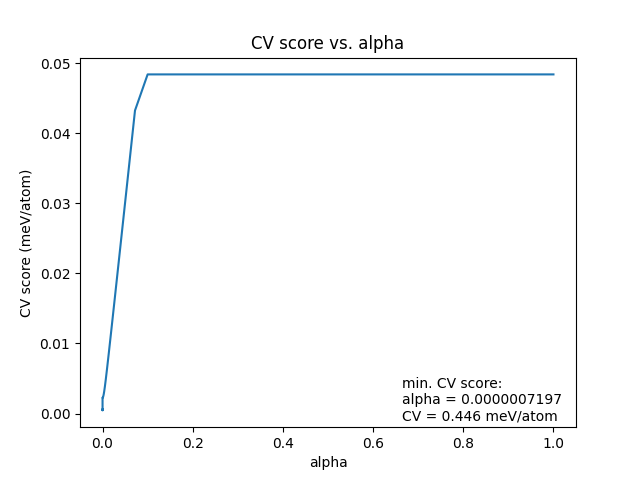

<IPython.core.display.Javascript object>


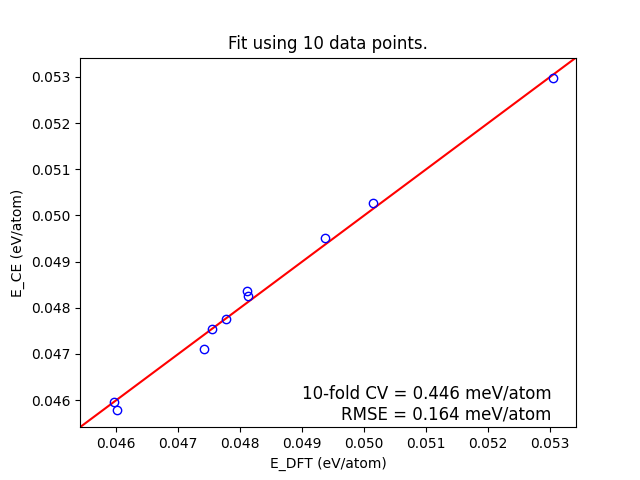

<IPython.core.display.Javascript object>


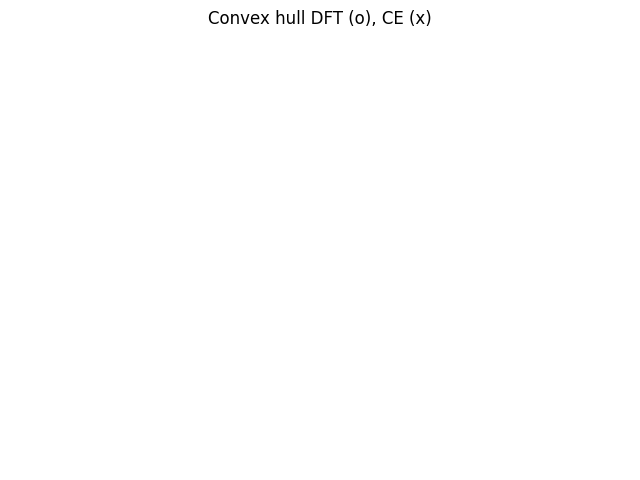

<IPython.core.display.Javascript object>


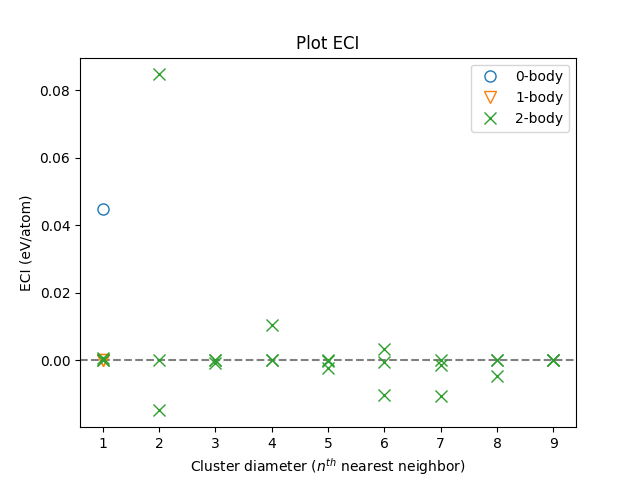

{'c0': 0.04482966469018917, 'c2_d0000_0_11': 0.0006839892636190956, 'c2_d0001_0_00': 0.08466500437727481, 'c2_d0001_0_11': -0.014832507222120138, 'c2_d0002_0_11': -0.0008990923043199946, 'c2_d0003_0_00': 0.010427518638911953, 'c2_d0004_0_01': -7.89342422199724e-05, 'c2_d0004_0_11': -0.002222194414144464, 'c2_d0005_0_00': 0.0033283210228272193, 'c2_d0005_0_01': -0.010251207295101062, 'c2_d0005_0_11': -0.0005189967090166385, 'c2_d0006_0_01': -0.010493627638426617, 'c2_d0006_0_11': -0.0014909464151783747, 'c2_d0007_0_00': -0.004548544130370087}


In [14]:
%matplotlib notebook
from clease import Evaluate
import clease.plot_post_process as pp

eva = Evaluate(settings=settings, fitting_scheme='l1', scoring_scheme='k-fold', nsplits=10)

# scan different values of alpha and return all values of alpha and its corresponding CV scores
alphas, cvs = eva.alpha_CV(alpha_min=1E-7, alpha_max=1.0, num_alpha=50)
pp.plot_cv(eva)

# set the alpha value to the one that yields the lowest CV score, and fit data using it.
idx = cvs.argmin()
alpha = alphas[idx]
eva.set_fitting_scheme(fitting_scheme='l1', alpha=alpha)
eva.get_eci()
pp.plot_fit(eva)

# plot convex hull.
pp.plot_convex_hull(eva)

# plot ECI values, an emptry list is passed to ignore_sizes to plot all cluster sizes 
pp.plot_eci(eva)

# print dictionary containing cluster names and their ECIs
print(eva.get_eci_dict())

# save a dictionary containing cluster names and their ECIs
eva.save_eci(fname='cluster_name_eci_l1.json')

Does the fit we generate with our best model look reasonable? Does it align with what one might expect from a model which was trained on 10 randomly generated structures?

## Generation of probe structures for further training structures

You have now seen the initial cross validation (CV) score using 10 initial training structures. We can further train the CE model using more training structures to make it more robust. 

CLEASE supports 3 ways to generate more strucures. The first (and most obvious) is generating random structures as you have already done. The second method is to generate so called "probe structures" which differ the most from the existing training structures in the database. The third method is to generate ground-state structures predicted based on current CE model.

You can generate probe structures using the following script. Note that it internally uses simulated annealing algorithm which uses fictitious temperature values to maximize the difference in correlation function of the new structure. 

In [24]:
ns = NewStructures(settings=settings, struct_per_gen=5, check_exists_in_db=False)
ns.generate_probe_structure()
print("Done")

Done


Once 10 additional structures are generated, you can re-run the script in "Running calculations on generated structures" section to calculate their energies. You should also run the script in "Evaluation of the CE model" section to evaluate the CV score of the model.

It is likely that the CV score of the model is sufficiently low (few meV/atom or less) at this point. 


## Generate ground-state structures


Ultimately, we are interested in the ground-state structures, or the structures with the lowest possible energy in our configurational space. In CLEASE, we achieve this using a simmulated annealing (SA) approach, which is what is done when we use the `generate_gs_structure` method.

Running SA can be costly, so we'll only run one at a time. If you want to make more, you can simple run the cell below multiple times.

In [25]:
import json

# get template with the cell size = 6x6x6
template = db.get("name=primitive_cell").toatoms()*(4, 4, 1)

# import dictionary containing cluster names and their ECIs
with open('cluster_name_eci_l1.json') as f:
    eci = json.load(f)

print(template,'\n')
print(eci)

ns = NewStructures(settings=settings, struct_per_gen=3, check_exists_in_db=False)

ns.generate_gs_structure(atoms=template, eci=eci,
                         init_temp=2000, final_temp=1, 
                         num_temp=10, num_steps_per_temp=5000,
                         random_composition=True)
print("Done")

Atoms(symbols='Pt144X144', pbc=True, cell=[[11.030865786510143, 0.0, 0.0], [5.515432893255071, 9.553009996854394, 0.0], [0.0, 0.0, 40.529988897111735]], tags=...) 

{'c0': 0.04482966469018917, 'c2_d0000_0_11': 0.0006839892636190956, 'c2_d0001_0_00': 0.08466500437727481, 'c2_d0001_0_11': -0.014832507222120138, 'c2_d0002_0_11': -0.0008990923043199946, 'c2_d0003_0_00': 0.010427518638911953, 'c2_d0004_0_01': -7.89342422199724e-05, 'c2_d0004_0_11': -0.002222194414144464, 'c2_d0005_0_00': 0.0033283210228272193, 'c2_d0005_0_01': -0.010251207295101062, 'c2_d0005_0_11': -0.0005189967090166385, 'c2_d0006_0_01': -0.010493627638426617, 'c2_d0006_0_11': -0.0014909464151783747, 'c2_d0007_0_00': -0.004548544130370087}


RuntimeError: Could not find <bound method NewStructures.num_to_gen of <clease.structgen.new_struct.NewStructures object at 0x7f7986c30700>> unique compositions using the provided Atoms object.

Again, you should re-run the scripts in "Running calculations on generated structures" and "Evaluation of the CE model" sections to see the convex-hull plot and the latest CV score of the model. If you observe that the CV score is high (more than ~5 meV/atom), you may want to repeat running the script for generating ground-state structures. 

If you want to generate ground-state structures at the three concentrations in which stable ordered phase exist (Au$_3$Cu, AuCu, AuCu$_3$), you can alternatively run the scripts below.

## Analyzing the concentration per layer

Recall that Cao and Mueller reported their Pt and Ni concentrations per layer, which is the result we were originally attempting to reproduce. Their results looked like this:

<img src="slab_ref.png" style="width: 600px;"/>

i.e. we see 100% Pt in the first layer, and then some Pt/Ni mixing in the subsequent layers.

In the cell below, we provide some helper functions to create such a figure from our result. The figure will be generated from the atoms object we found which has the lowest energy per atom. Just simply run them to define the functions - but feel free to try and understand what is going on.

In [17]:
import collections
import matplotlib.pyplot as plt
import numpy as np


def find_layers(slab, tol=1e-3):
    """Identify each layer in a slab"""
    layers = []  # z-position of a layer

    for atom in slab:
        if atom.symbol == 'X':
            continue
        z = atom.z
        found = False
        for layer in layers:
            if abs(z - layer) < tol:
                found = True
                break
        if found is False:
            # We found a new layer
            layers.append(z)

    return sorted(layers)


def get_conc_in_layers(slab, tol=1e-3):
    """Get the concentration within each layer"""
    layers = find_layers(slab, tol=tol)
    concs = []

    for ii, layer in enumerate(layers):
        # Find atoms in this layer
        mask = abs(slab.positions[:, 2] - layer) < tol
        atoms_layer = slab[mask]
        counts = collections.Counter(atoms_layer.symbols)
        tot = len(atoms_layer)
        conc = {sym: c / tot for sym, c in counts.items()}
        concs.append(conc)
    return concs


def plot_conc_in_layers(concs):
    """ Plot the concentration in each layer.
    Concs here is the output from get_conc_in_layers."""

    fig, ax = plt.subplots()

    # Get all available symbols
    all_syms = set()
    for conc in concs:
        for sym in conc.keys():
            all_syms.add(sym)

    n_layers = len(concs)
    base_heights = np.zeros(n_layers)
    for sym in sorted(all_syms, reverse=True):
        # Generate the height for each layer
        heights = np.array([conc.get(sym, 0) for conc in concs])
        labels = [f'{i+1}' for i in range(len(concs))]
        ax.bar(labels, heights, label=sym, bottom=base_heights)
        # Stack the bars on top of eachother
        base_heights += heights

    ax.set_ylabel('Fraction [at%]')
    ax.set_xlabel('Layer #')
    ax.legend(loc='best')

    return fig

def get_emin_struct(db_name):
    """Get the row with the lowest energy per atom in the database"""
    con = connect(db_name)

    emin_row = None
    emin = np.infty
    # Notice we did not optimize the initials, so we can just access the finals directly, and compare those
    rows = con.select(struct_type='final')
    # Go through the finals, and find emin
    for row in rows:
        en = row.energy / row.natoms
        if en < emin:
            # Set the newest emin row
            emin_row, emin = row, en
    return emin_row

We can use our helper functions on our newly generated data as follows:

Emin_row id: 20
[{'Ni': 0.25, 'Pt': 0.75}, {'Pt': 0.75, 'Ni': 0.25}, {'Pt': 0.6875, 'Ni': 0.3125}, {'Ni': 0.25, 'Pt': 0.75}, {'Ni': 0.375, 'Pt': 0.625}, {'Ni': 0.25, 'Pt': 0.75}, {'Pt': 0.75, 'Ni': 0.25}, {'Pt': 0.875, 'Ni': 0.125}, {'Pt': 0.8125, 'Ni': 0.1875}]


<IPython.core.display.Javascript object>


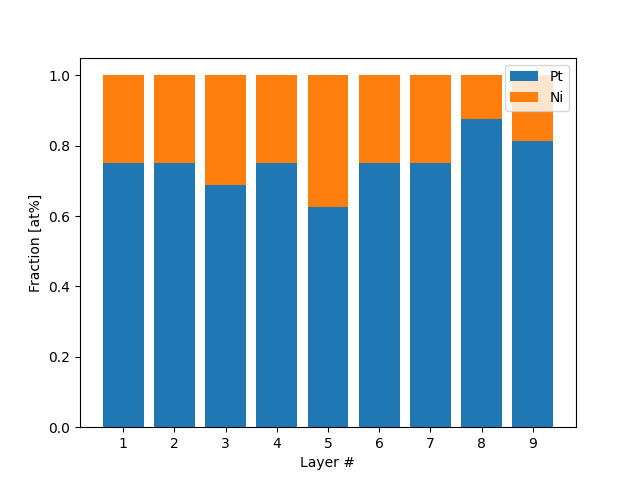

In [18]:
emin_row = get_emin_struct('clease.db')
print('Emin_row id:', emin_row.id)
atoms = emin_row.toatoms()

concs = get_conc_in_layers(atoms)
print(concs)
fig = plot_conc_in_layers(concs)


How well did we reproduce the results from Cao and Mueller? Try and see if you can improve upon the fit by adding more data, and improving the CE model!